In [18]:
import sys
from pathlib import Path
from os.path import dirname, abspath
d = dirname(abspath(Path.cwd()))
sys.path.insert(0, d)
import pickle
import config
import os
from matplotlib import pyplot as pl
import numpy as np
import shap
from os.path import exists
from Utils.feature_set_info import FeatureSetInfo
from collections import OrderedDict
import hyper_params
import math
import torch

In [19]:
NUM_MESUREMENTS = 100  #600
SHOULD_DO_GRID_SEARCH = False
NUM_HOURS_FOR_WINDOW = 4
MODEL_NAME = "Transformermimiciv"
ADDITIONAL_NAME_FOR_EXPERIMENT = hyper_params.CURR_TASK + ("" if hyper_params.CONDUCT_TRANSFER_LEARNING else '_no_transfer')
NUM_MOST_IMPORTANT_FEATURES = -1
TASK = 'mimiciv_' + hyper_params.CURR_TASK + '_' + str(NUM_MESUREMENTS) + '_' +str(NUM_HOURS_FOR_WINDOW) +'h'

In [20]:
shap_data_path = config.DEFAULT_SAVE_LOC + '/shap_results'
if exists(shap_data_path):
    with open(shap_data_path, "rb") as pickle_file:
        shap_results = pickle.load(pickle_file)


shap_values = shap_results['shap_values']
explain_data = shap_results['explain_data'][shap_results['explain_data'].shape[0] // 2:, : , :]
#expected_value = shap_results['expected_value']
person_indices = shap_results['person_indices'].detach().cpu().numpy()
data = shap_results['data'][shap_results['data'].shape[0] // 2:, : , :]
dataset_dict = shap_results['dataset_dict']
model_pred = shap_results['model_pred']

In [ ]:
feature_set_path = config.DEFAULT_SAVE_LOC + '/featureset_' + TASK + '_' + str(NUM_MESUREMENTS) + '_' + str(NUM_HOURS_FOR_WINDOW) \
                    + '_' + MODEL_NAME
print(feature_set_path)
if os.path.isfile(feature_set_path):
    print(":")
    with open(feature_set_path, 'rb') as pickle_file:
        featureSetInfo = pickle.load(pickle_file)


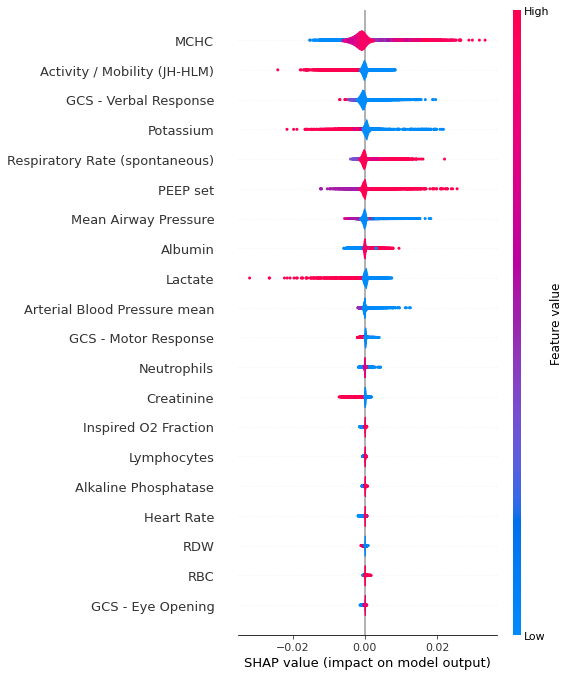

['Activity / Mobility (JH-HLM)', 'Alanine Aminotransferase (ALT)', 'Albumin', 'Alkaline Phosphatase', 'Arterial Blood Pressure mean', 'Asparate Aminotransferase (AST)', 'Creatinine', 'GCS - Eye Opening', 'GCS - Motor Response', 'GCS - Verbal Response', 'Heart Rate', 'Hematocrit', 'Hemoglobin', 'Inspired O2 Fraction', 'Lactate', 'Lymphocytes', 'MCHC', 'Magnesium', 'Mean Airway Pressure', 'Neutrophils', 'Non Invasive Blood Pressure diastolic', 'Non Invasive Blood Pressure systolic', 'O2 saturation pulseoxymetry', 'PEEP set', 'PT', 'Potassium', 'RBC', 'RDW', 'Respiratory Rate (spontaneous)', 'Respiratory Rate']


<Figure size 432x288 with 0 Axes>

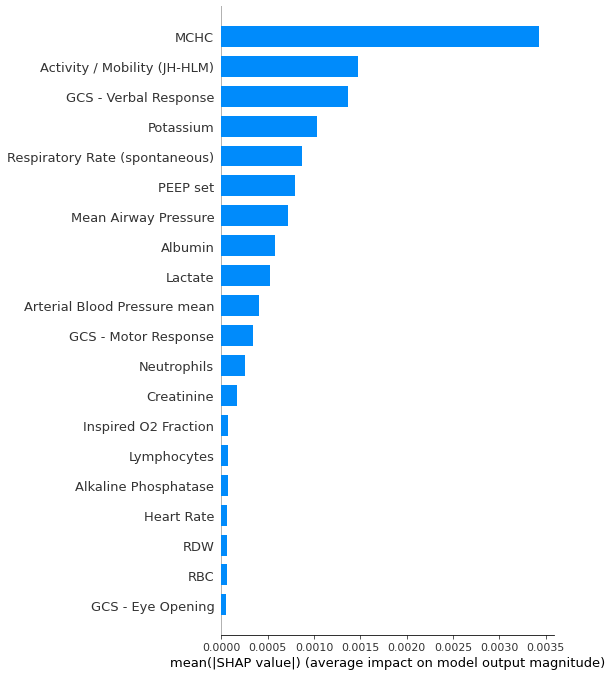

['Activity / Mobility (JH-HLM)', 'Alanine Aminotransferase (ALT)', 'Albumin', 'Alkaline Phosphatase', 'Arterial Blood Pressure mean', 'Asparate Aminotransferase (AST)', 'Creatinine', 'GCS - Eye Opening', 'GCS - Motor Response', 'GCS - Verbal Response', 'Heart Rate', 'Hematocrit', 'Hemoglobin', 'Inspired O2 Fraction', 'Lactate', 'Lymphocytes', 'MCHC', 'Magnesium', 'Mean Airway Pressure', 'Neutrophils', 'Non Invasive Blood Pressure diastolic', 'Non Invasive Blood Pressure systolic', 'O2 saturation pulseoxymetry', 'PEEP set', 'PT', 'Potassium', 'RBC', 'RDW', 'Respiratory Rate (spontaneous)', 'Respiratory Rate']


<Figure size 432x288 with 0 Axes>

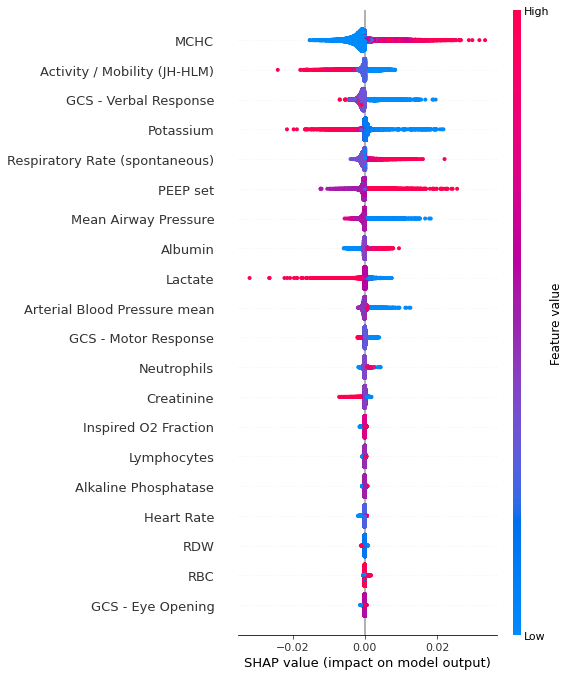

['Activity / Mobility (JH-HLM)', 'Alanine Aminotransferase (ALT)', 'Albumin', 'Alkaline Phosphatase', 'Arterial Blood Pressure mean', 'Asparate Aminotransferase (AST)', 'Creatinine', 'GCS - Eye Opening', 'GCS - Motor Response', 'GCS - Verbal Response', 'Heart Rate', 'Hematocrit', 'Hemoglobin', 'Inspired O2 Fraction', 'Lactate', 'Lymphocytes', 'MCHC', 'Magnesium', 'Mean Airway Pressure', 'Neutrophils', 'Non Invasive Blood Pressure diastolic', 'Non Invasive Blood Pressure systolic', 'O2 saturation pulseoxymetry', 'PEEP set', 'PT', 'Potassium', 'RBC', 'RDW', 'Respiratory Rate (spontaneous)', 'Respiratory Rate']


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [22]:
def check_if_row_contains_zeros (mat):
    for i in range(mat.shape[1]):
        if (~mat[:, i].any()).any():
            return True
    return False

# feature_names = featureSetInfo.numeric_feature_to_index
# index_to_numeric_feature = {val: key for key, val in feature_names.items()}
# code_names = featureSetInfo.feature_codes_to_id
# feature_names = [x[1] for x in sorted(list({num: name for name, num in 
#                 feature_names.items()}.items()), key = lambda x: x[0])] + [x[1] for x in sorted(list({num: name for name, num in 
#                 code_names.items()}.items()), key = lambda x: x[0])]

feature_names = {k: v for k, v in featureSetInfo.numeric_feature_to_index.items() if  v not in dataset_dict['not_good_features']}
feature_names = sorted(feature_names.items(), key = lambda x: x[1])
feature_names = [(y, x) for x, y in enumerate([x for x, _ in feature_names])]
feature_idx =  [x for _,x in feature_names]
# feature_names = [x for x, _ in feature_names]
feature_names_d = {k: v for k, v in featureSetInfo.feature_codes_to_id.items() if  v + len(featureSetInfo.numeric_feature_to_index) + featureSetInfo.num_non_numeric_features not in dataset_dict['not_good_features']}
feature_names_d = sorted(feature_names_d.items(), key = lambda x: x[1])
feature_names_d = [(y, x) for x, y in enumerate([x for x, _ in feature_names_d])]
feature_names = [x for x, _ in feature_names] + [x for x, _ in feature_names_d]
feature_names = [x[:x.index('--')] for x in feature_names]

for plot_type in ['violin', 'bar', 'dot']:
    i_shap_values = shap_values[1][:, :, :]

    num_time_frames = i_shap_values.shape[1]
    examples = [i_shap_values[:, i, :] for i in range(num_time_frames)]
    example = np.concatenate(examples, axis=0)
    feature_vals_arr = [explain_data.numpy()[:, i, :] for i in range(num_time_frames)]
    feature_vals = np.concatenate(feature_vals_arr, axis = 0)
    shap.summary_plot(example, features = feature_vals, 
    feature_names = feature_names, plot_type = plot_type, 
    title = "Plot using median shap values for time")
    print(feature_names)
    fig = pl.figure()
    pl.show()
    pl.clf()

In [ ]:
shap.initjs()
feature_names = featureSetInfo.numeric_feature_to_index
feature_names = [x[1] for x in sorted(list({num: name for name, num in 
                feature_names.items()}.items()), key = lambda x: x[0])] 
n_visits = {p: math.ceil(np.max(np.array(featureSetInfo.window_times_for_person[p])).astype('timedelta64[h]').astype(int) / NUM_HOURS_FOR_WINDOW) for p in person_indices }
print("eICU Stay: ", person_indices[0])
shap.force_plot(expected_value[0], shap_values[1][0, :n_visits[person_indices[0]], :featureSetInfo.num_numeric_features], feature_names)





In [ ]:
print("Red is positive, blue is negative")
# %%
import seaborn as sns
from Generators.explanationGenerator import explain_feature
max_time_frames = 30
values_plot = shap_values[1]
all_min = []
all_max = []
person_indices = person_indices[len(person_indices) // 2:]
for i, p in enumerate(person_indices):
    values_plot[i, :, :] = (values_plot[i, :, :]-values_plot[i, :, :].mean()) / (values_plot[i, :, :].std())
for i in range(featureSetInfo.num_numeric_features):
    df = explain_feature(data, person_indices, n_visits, values_plot, model_pred, i, dataset_dict['norm_info'], max_time_frames)
    sns.scatterplot(alpha=0.5, data = df, x = "Time Frame", y = "Value", hue="Score", palette = "bwr", hue_norm = ((-1, 1))).set(title = index_to_numeric_feature[i])
    pl.show()
    pl.clf()

Idea for calculating interactions, based on "Interpreting Multivariate Shapley Interactions in DNNs" by Zhang et al.
Interaction between features i and j are formulized as:

$$ B(S_{i j}) = \phi(S_{i j} | N') - [\phi(i | N_{i}) + \phi(j | N_{j})] = \\ \phi(S_{i j} | N \backslash  \{i, j\} \cup S_{i j}) - [\phi(i | N \backslash  \{j\}) + \phi(j | N \backslash  \{i\})] = \phi_1 - [\phi_2 + \phi_3]$$

Where:
$$\phi_1 = \phi(S_{i j} | N \backslash  \{i, j\} \cup S_{i j}) $$
$$\phi_2 = \phi(i | N \backslash  \{j\})$$
$$\phi_3 = \phi(j | N \backslash  \{i\})$$